In [1]:
%matplotlib inline
from IPython.display import Image
import numpy.matlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import openpyxl
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D

import xml.etree.ElementTree as ET
from subprocess import call
import vtk
from vtk.util.numpy_support import vtk_to_numpy
from scipy.interpolate import griddata

import openmc

import Define_Nektar
import Define_OpenMC

import os

In [2]:
# Parameters of reactor
# Unit: cm
# To be discussed: Parameters for reactor to become critical
parameters_dic = {}

parameters_dic.update(fuel_r = 11/2)
parameters_dic.update(fuel_h = 19.5)

parameters_dic.update(controlRod_r = 4.4/2)
parameters_dic.update(controlRod_h_max = 27)
parameters_dic.update(controlRod_l = 24.5)

parameters_dic.update(reflector_r = 42/2)
parameters_dic.update(reflector_h = 32)

parameters_dic.update(heat_pipe_R = 1.27/2)
parameters_dic.update(heat_pipe_r = 1.27/2-0.1)

parameters_dic.update(top_distance = 10.5)
parameters_dic.update(bottom_distance = 5)

parameters_dic.update(heat_power = 4000)

temp_pipe = 1173.5
# Insert control rod, maximum is 27
controlRod_deep = 0
# Number of cells
cells_num_dic = {'n_r':10,'n_r_outer':5,'n_h':20}
# Settings of OpenMC
settings_dic = {'batches':20,'inactive':10,'particles':1000}
#Settings of Nektar++
file_name = 'HeatPipeReactor' # fiel_name.xml with settings of Poisson solver
solver_name = 'ADRSolver' 
# Number of iteration
iteration = 10
k_eff = np.zeros(10)
# Initial temperature distribution in cells
Initial_temperature = 1173.5
temp_cells_mat = Initial_temperature*np.ones((cells_num_dic['n_h'],(cells_num_dic['n_r_outer']+cells_num_dic['n_r'])))
# Get some data
r_axe,h_axe,volume_mat,fuel_cell_ID_list = Define_OpenMC.define_Geo_Mat_Set(cells_num_dic,parameters_dic,settings_dic,temp_cells_mat,controlRod_deep)
x,y,z = Define_Nektar.readNodesFromVtu(file_name)
nodes_dic = {'x':x,'y':y,'z':z}
# Initial temperature distribution in nodes
temp_nodes_vec = Initial_temperature*np.ones(len(x))

# For Test
error_vec = np.zeros(iteration)

In [3]:
for i in range(iteration):
    # For Test
    temp_cells_mat_last = temp_cells_mat
    
    # Iteration
    print('Iteration = '+str(i+1)+' begins')
    # Run OpenMC !
    openmc.run(output=False)
    # Post-process the result of heat source and generate Force.pts
    k_ave = Define_OpenMC.postProcess(nodes_dic,volume_mat,temp_nodes_vec,parameters_dic,cells_num_dic,settings_dic,fuel_cell_ID_list)
    k_eff[i] = k_ave
    # Run Nektar++
    file_name_new = Define_Nektar.runNektar(file_name,solver_name,temp_pipe,i)
    # Post-process result of temperature
    temp_nodes_vec = Define_Nektar.postProcess(file_name_new)
    
    temp_cells_mat = Define_OpenMC.getCellTemperature(nodes_dic,temp_nodes_vec,parameters_dic,cells_num_dic)

    Define_OpenMC.editCellTemperature(temp_cells_mat,fuel_cell_ID_list)
    # For Test

    error = np.abs(temp_cells_mat-temp_cells_mat_last)/temp_cells_mat_last
    error_vec[i] = error.sum()/(np.size(error,0)*np.size(error,1))

Iteration = 1 begins
Iteration = 2 begins
Iteration = 3 begins
Iteration = 4 begins
Iteration = 5 begins
Iteration = 6 begins
Iteration = 7 begins
Iteration = 8 begins
Iteration = 9 begins
Iteration = 10 begins


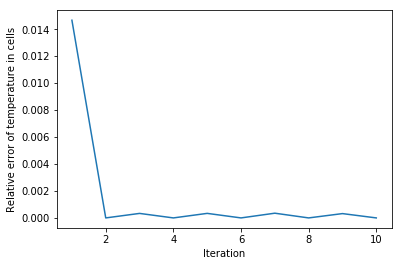

In [4]:
iteration_vec = np.linspace(1,iteration,iteration)
plt.plot(iteration_vec,error_vec)
plt.xlabel('Iteration')
plt.ylabel('Relative error of temperature in cells')
plt.show()

In [5]:
# iteration_vec = np.linspace(1,iteration,iteration)
# plt.plot(iteration_vec,k_eff)
# plt.xlabel('Iteration')
# plt.ylabel('k-effective')
# plt.show()

In [7]:
print(error_vec)

[0.01466242 0.         0.00033424 0.         0.00033683 0.
 0.00035007 0.         0.00032019 0.        ]
